## Preprocess and Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")



### Creating Dataframes from image data 

In [2]:
def create_dataframe_from_directory(directory):

    label = []
    path = []
    
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname, filename))
    
    # Create the DataFrame
    df = pd.DataFrame({'path': path, 'label': label})
    
    return df


# Create DataFrames for each directory
df_test = create_dataframe_from_directory("data/test")
df_train = create_dataframe_from_directory("data/train")
df_valid = create_dataframe_from_directory("data/valid")



In [22]:
df_train

,path,label
0,data/train\ABBOTTS BABBLER\001.jpg,ABBOTTS BABBLER
1,data/train\ABBOTTS BABBLER\002.jpg,ABBOTTS BABBLER
2,data/train\ABBOTTS BABBLER\003.jpg,ABBOTTS BABBLER
3,data/train\ABBOTTS BABBLER\004.jpg,ABBOTTS BABBLER
4,data/train\ABBOTTS BABBLER\005.jpg,ABBOTTS BABBLER
...,...,...
18743,data/train\BUSH TURKEY\156.jpg,BUSH TURKEY
18744,data/train\BUSH TURKEY\157.jpg,BUSH TURKEY
18745,data/train\BUSH TURKEY\158.jpg,BUSH TURKEY
18746,data/train\BUSH TURKEY\159.jpg,BUSH TURKEY


### Identifying Labels

In [24]:

# Assuming df_train is your DataFrame
class_names = df_train['label'].unique()

# Creating a DataFrame with one column containing the unique values
class_names = pd.DataFrame(class_names, columns=['label'])

# Save the DataFrame to a CSV file
class_names.to_csv('class_names.csv', index=False)

# Convert the unique class names to a list
class_names = class_names["label"].tolist()
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

### Preprocessing and Data Augmentation

Found 18748 validated image filenames belonging to 118 classes.
Found 590 validated image filenames belonging to 118 classes.
Found 590 validated image filenames belonging to 118 classes.


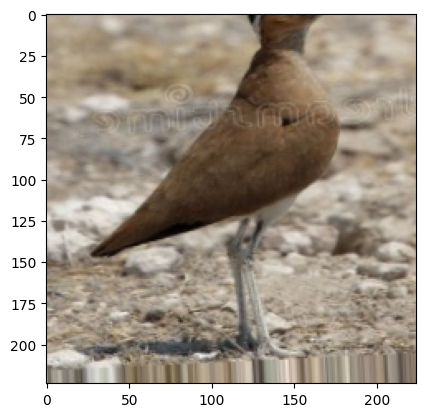

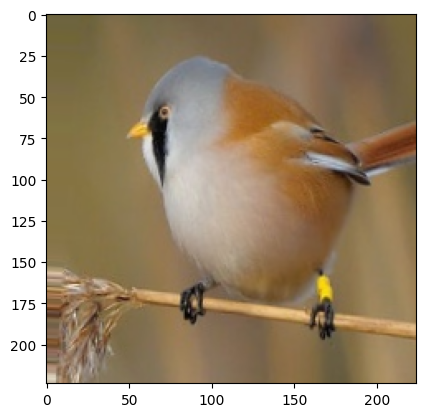

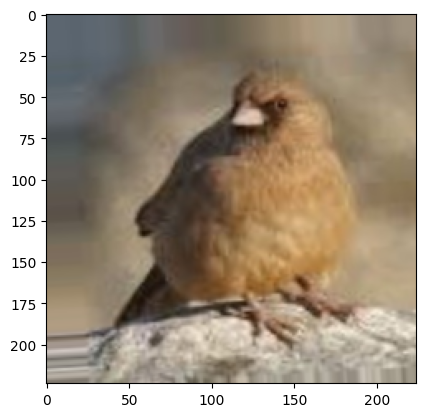

In [41]:
BS = 32
image_size = (224,224)
image_shape=(224,224,3)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, x_col='path', y_col='label',
    target_size=image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_valid, x_col='path', y_col='label',
    target_size=image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_test, x_col='path', y_col='label',
    target_size=image_size,
    batch_size=BS,
    class_mode='categorical',
    color_mode='rgb'
)

# Display a few sample images
for _ in range(3):
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.show()


### Building Model

In [45]:

base_model = tf.keras.applications.InceptionResNetV2(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet'
    )
base_model.trainable = False


def build_model(base_model):
    inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input-layer")
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(118, activation="softmax", name="output-layer")(x)
    model = tf.keras.Model(inputs, outputs)



    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, valid_generator):

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=20,
        verbose=1,
        callbacks=[early_stop]
    )
    
    # Convert history to DataFrame
    result = pd.DataFrame(history.history)
    
    return result

def plot_training_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax = ax.flatten()
    ax[0].plot(history[['accuracy', 'val_accuracy']])
    ax[0].set_title("Accuracy")
    ax[1].plot(history[['loss', 'val_loss']])
    ax[1].set_title("Loss")
    plt.show()


# Build model
model = build_model(base_model)

# Train model
history = train_model(model, train_generator, valid_generator)



Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1047s 2s/step - accuracy: 0.5222 - loss: 2.0418 - val_accuracy: 0.8288 - val_loss: 0.5775
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1011s 2s/step - accuracy: 0.8046 - loss: 0.6858 - val_accuracy: 0.8797 - val_loss: 0.4325
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.8492 - loss: 0.5266 - val_accuracy: 0.8729 - val_loss: 0.3775
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.8660 - loss: 0.4600 - val_accuracy: 0.8847 - val_loss: 0.3333
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1004s 2s/step - accuracy: 0.8779 - loss: 0.4107 - val_accuracy: 0.9136 - val_loss: 0.3299
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.8910 - loss: 0.3669 - val_accuracy: 0.9000 - val_loss: 0.3087
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.8997 - loss: 0.3249 - val_accuracy: 0.9119 - val_loss: 0.2793
Epoch 8/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 1010s 2s/step - accuracy: 0.9026 - loss: 0.3254 - va

### Model Testing


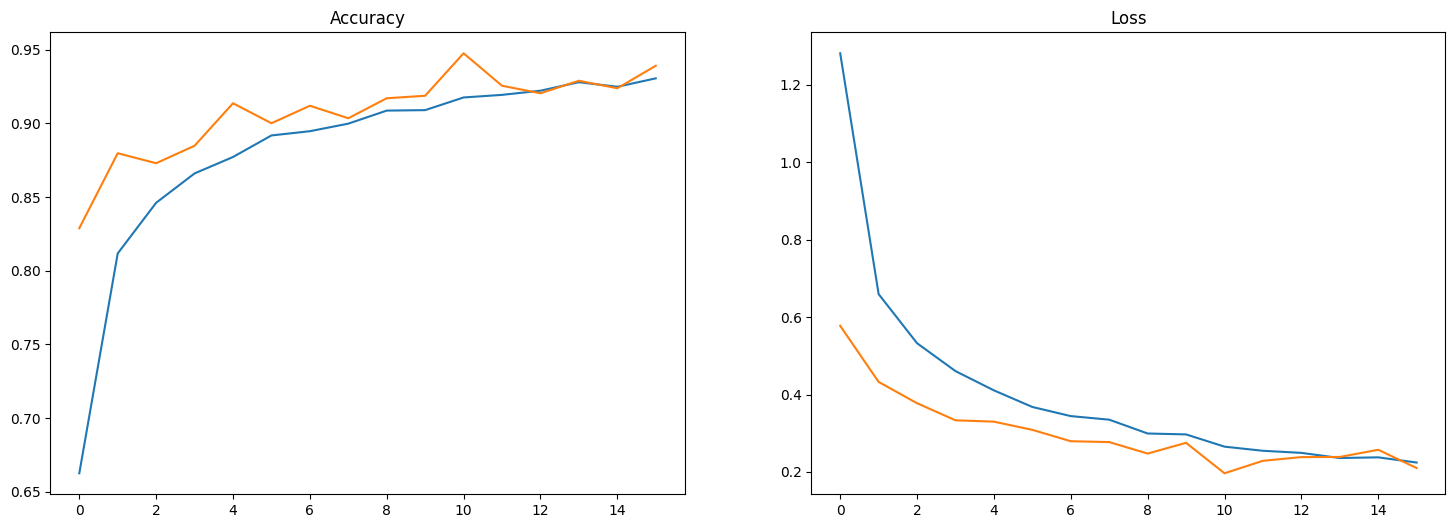

In [53]:
def plot_training_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    ax = ax.flatten()
    ax[0].plot(history[['accuracy', 'val_accuracy']])
    ax[0].set_title("Accuracy")
    ax[1].plot(history[['loss', 'val_loss']])
    ax[1].set_title("Loss")
    plt.show()

# Plot training history
plot_training_history(history)


In [54]:

test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9728 - loss: 0.1129
Test Loss: 0.14316803216934204
Test Accuracy: 0.9559321999549866


In [55]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input-layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ (None, 118)            │       181,366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,880,836 (209.35 MB)

 Trainable params: 181,366 (708.46 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 362,734 (1.38 MB)

### Saving Model

In [56]:
model_save_path = 'models/cnn_final.keras'

model.save(model_save_path)



### Load Model and New Image Testing

In [58]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to preprocess the image and make predictions
def preprocess_image_and_predict(model, img_path, class_names):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    
    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_names[predicted_class_index]
    
    return predicted_class_index, predicted_class_label

In [59]:

print("Loading the model...")

model_path = 'models/cnn_final.keras'

try:
    loaded_model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading the model:", e)


Loading the model...
Model loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


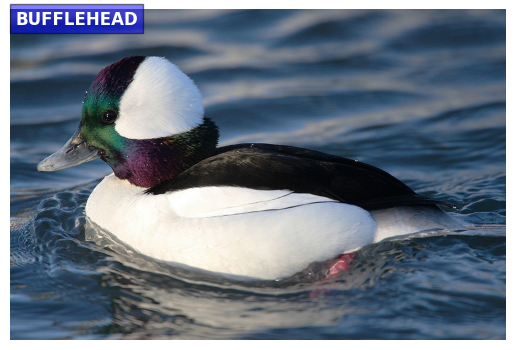

In [60]:
test_image_path = 'data/bufflehead.jpg'

# Get the predicted class index and label
predicted_class_index, predicted_class_label = preprocess_image_and_predict(loaded_model, test_image_path, class_names)

# Load and display the image
img = image.load_img(test_image_path)
plt.imshow(img)
plt.axis('off')

# Add the predicted class label as text
plt.text(10, 30, f'{predicted_class_label}', color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='blue', alpha=0.5))

plt.show()